# Geoinformatika 

#### Strojové učení v geoinformatice

### Zadání semestrální úlohy 

**Klasifikace Land Cover pomocí rozhodovacího stromu** 

**Cílem** této úlohy je vytvořit a generalizovat rozhodovací strom (Decision Tree, DT) pro klasifikaci land cover na základě daných vstupních dat. Vzhledem k povaze dat bude třeba řešit několik problémů, které ovlivňují výkonnost a interpretaci modelu.

*Popis dat:* 

Vstupní proměnné: Data obsahují různé environmentální a DPZ charakteristiky (např. vegetační indexy, spektrální pásma, nadmořskou výšku, vlhkost půdy aj.).

*Specifika dat*:
- Obsahují šum, což může negativně ovlivnit tvorbu rozhodovacích pravidel.
- Mezi třídami existují překryvy (např. podobnost spektrálních vlastností mezi dvěma typy vegetace), což snižuje přesnost klasifikace.
- Pro dosažení vysoké přesnosti může být vyžadována tvorba hlubokého stromu, který je však náchylný k přeučení na šum nebo irelevantní vzory.

*Cíle úlohy*:
* Naučit rozhodovací strom klasifikovat typy land cover:
* Třídy: les, voda, zemědělská půda, městská zástavba, mokřady.
* Generalizovat model: Minimalizovat přeučení stromu na šum a zlepšit jeho schopnost generalizace na nová, neviděná data. 

### Postup řešení

In [58]:
# Knihovny
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [59]:
# nastavte vlatní hodnotu seed
seed_no = 6

In [60]:
# Počet vzorků
n_samples = 100000

In [61]:
ndvi = np.random.uniform(0, 1, n_samples)
ndwi = np.random.uniform(0, 1, n_samples)
rgb = np.random.uniform(0, 255, (n_samples, 3))
altitude = np.random.uniform(0, 2000, n_samples)
noise = np.random.uniform(0, 1, n_samples)

In [62]:
# Definice třídy na základě překrývajících se pravidel
labels = []
for i in range(n_samples):
    if ndvi[i] > 0.6 and ndwi[i] < 0.3:
        labels.append('les' if np.random.rand() > 0.1 else 'město')  # Přidání šumu
    elif ndvi[i] < 0.3 and ndwi[i] > 0.6:
        labels.append('voda')
    elif rgb[i, 0] > 200:
        labels.append('město')
    else:
        labels.append('trávník')


In [63]:
# Náhodné zamíchání špatných štítků
labels = np.array(labels)
for i in range(int(n_samples * 0.1)):
    labels[np.random.randint(0, n_samples)] = np.random.choice(['les', 'voda', 'město', 'trávník'])


In [64]:
# Vytvoření datové sady
df = pd.DataFrame({
    'NDVI': ndvi,
    'NDWI': ndwi,
    'Red': rgb[:, 0],
    'Green': rgb[:, 1],
    'Blue': rgb[:, 2],
    'Altitude': altitude,
    'Noise': noise,
    'Label': labels
})

In [65]:
# NDVI .. Altitude jsou vstpní proměnné, X
# Label je kategorie Lansd Cover, y

df.head()

x=df.drop("Label", axis=1)
x=x.drop("Noise", axis=1)

y=df["Label"]

### Modelování

In [66]:
from sklearn import tree
from sklearn.model_selection import train_test_split

#výběr trénovacích dat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, train_size = 0.70, random_state = 166)

clf = tree.DecisionTreeClassifier(
    max_depth=6,            #maximální hloubka grafu
    min_samples_leaf=20,    #minimální počet vzorků, které musí být v každém listovém uzlu
    max_features=0.7,        #maximální procento proměnných braných do úvahy při každém větvení
    random_state=16
)

# Trénování modelu
clf.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=6, max_features=0.7, min_samples_leaf=20,
                       random_state=16)

### Hodnocení modelu

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(x_test)    #model predikuje třídu land coveru (y) na základě parametrů x pro testová data
print("Přesnost klasifikace:")
print(classification_report(y_test, y_pred))

print("Chybová matice:")
print(confusion_matrix(y_test, y_pred))

#Křížová validace - metrikou je zvoleno vážené f1 skóre
cv_scores = cross_val_score(clf, x, y, scoring="f1_weighted", cv=5)  # 5složková křížová validace
print("f1 skóre:", cv_scores)
print("Průměrné f1 skóre:", np.mean(cv_scores))


Přesnost klasifikace:
              precision    recall  f1-score   support

         les       0.84      0.83      0.84      3654
       město       0.93      0.83      0.88      5506
     trávník       0.93      0.98      0.95     16787
        voda       0.93      0.84      0.88      4053

    accuracy                           0.92     30000
   macro avg       0.91      0.87      0.89     30000
weighted avg       0.92      0.92      0.92     30000

Chybová matice:
[[ 3040   107   422    85]
 [  414  4569   425    98]
 [   72   113 16516    86]
 [   78   136   442  3397]]
f1 skóre: [0.91837118 0.91353599 0.9169302  0.91941653 0.91561073]
Průměrné f1 skóre: 0.9167729262096612


### Experimenty pro generalizaci
Práce s parametry: max_features, max_depth a min_samples_leaf

In [68]:
#fce pro vizualizaci výsledků při odlišných parametrech
def vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations):
    plt.figure(figsize=(12, 6))
    plt.plot(parameter_combinations, f1_test_list, label="F1 Test", marker="o")
    plt.plot(parameter_combinations, f1_train_list, label="F1 Train", marker="x")
    plt.xticks(rotation=90, fontsize=7)
    plt.xlabel("kombinace parametrů")
    plt.ylabel("F1 skóre")
    plt.title("Vývoj F1 pro různé kombinace parametrů")
    plt.legend()
    plt.grid()
    plt.show()

max_features: 0.7, max_depth: 1, min_samples_leaf: 20
F1_train: 0.610, F1_test: 0.606
max_features: 0.7, max_depth: 2, min_samples_leaf: 20
F1_train: 0.610, F1_test: 0.606
max_features: 0.7, max_depth: 3, min_samples_leaf: 20
F1_train: 0.730, F1_test: 0.728
max_features: 0.7, max_depth: 4, min_samples_leaf: 20
F1_train: 0.894, F1_test: 0.894
max_features: 0.7, max_depth: 5, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 6, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 7, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 8, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 9, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 10, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 11, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 12, min_samples_leaf: 

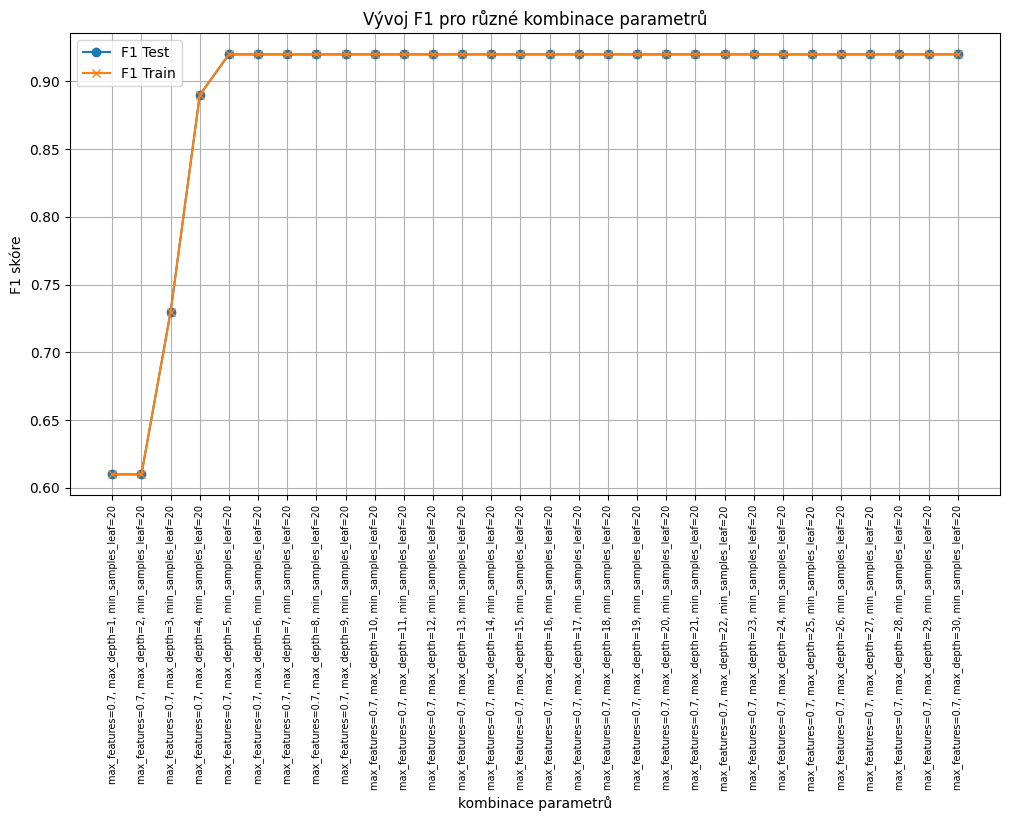

max_features: 0.7, max_depth: 6, min_samples_leaf: 1
F1_train: 0.917, F1_test: 0.915
max_features: 0.7, max_depth: 6, min_samples_leaf: 11
F1_train: 0.901, F1_test: 0.898
max_features: 0.7, max_depth: 6, min_samples_leaf: 21
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 6, min_samples_leaf: 31
F1_train: 0.917, F1_test: 0.916
max_features: 0.7, max_depth: 6, min_samples_leaf: 41
F1_train: 0.916, F1_test: 0.914
max_features: 0.7, max_depth: 6, min_samples_leaf: 51
F1_train: 0.916, F1_test: 0.914
max_features: 0.7, max_depth: 6, min_samples_leaf: 61
F1_train: 0.915, F1_test: 0.914
max_features: 0.7, max_depth: 6, min_samples_leaf: 71
F1_train: 0.911, F1_test: 0.909
max_features: 0.7, max_depth: 6, min_samples_leaf: 81
F1_train: 0.838, F1_test: 0.837
max_features: 0.7, max_depth: 6, min_samples_leaf: 91
F1_train: 0.815, F1_test: 0.812


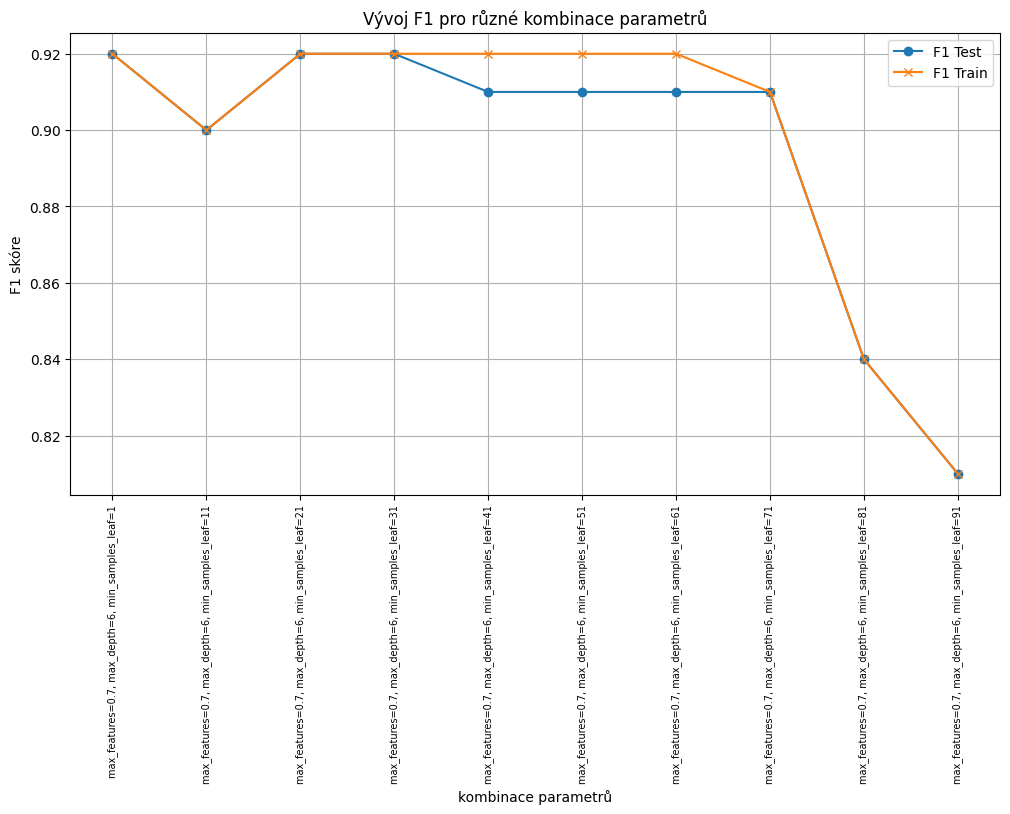

max_features: 0.1, max_depth: 6, min_samples_leaf: 20
F1_train: 0.493, F1_test: 0.488
max_features: 0.2, max_depth: 6, min_samples_leaf: 20
F1_train: 0.493, F1_test: 0.488
max_features: 0.30000000000000004, max_depth: 6, min_samples_leaf: 20
F1_train: 0.493, F1_test: 0.488
max_features: 0.4, max_depth: 6, min_samples_leaf: 20
F1_train: 0.910, F1_test: 0.907
max_features: 0.5, max_depth: 6, min_samples_leaf: 20
F1_train: 0.863, F1_test: 0.862
max_features: 0.6, max_depth: 6, min_samples_leaf: 20
F1_train: 0.863, F1_test: 0.862
max_features: 0.7000000000000001, max_depth: 6, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.8, max_depth: 6, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 0.9, max_depth: 6, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916
max_features: 1.0, max_depth: 6, min_samples_leaf: 20
F1_train: 0.917, F1_test: 0.916


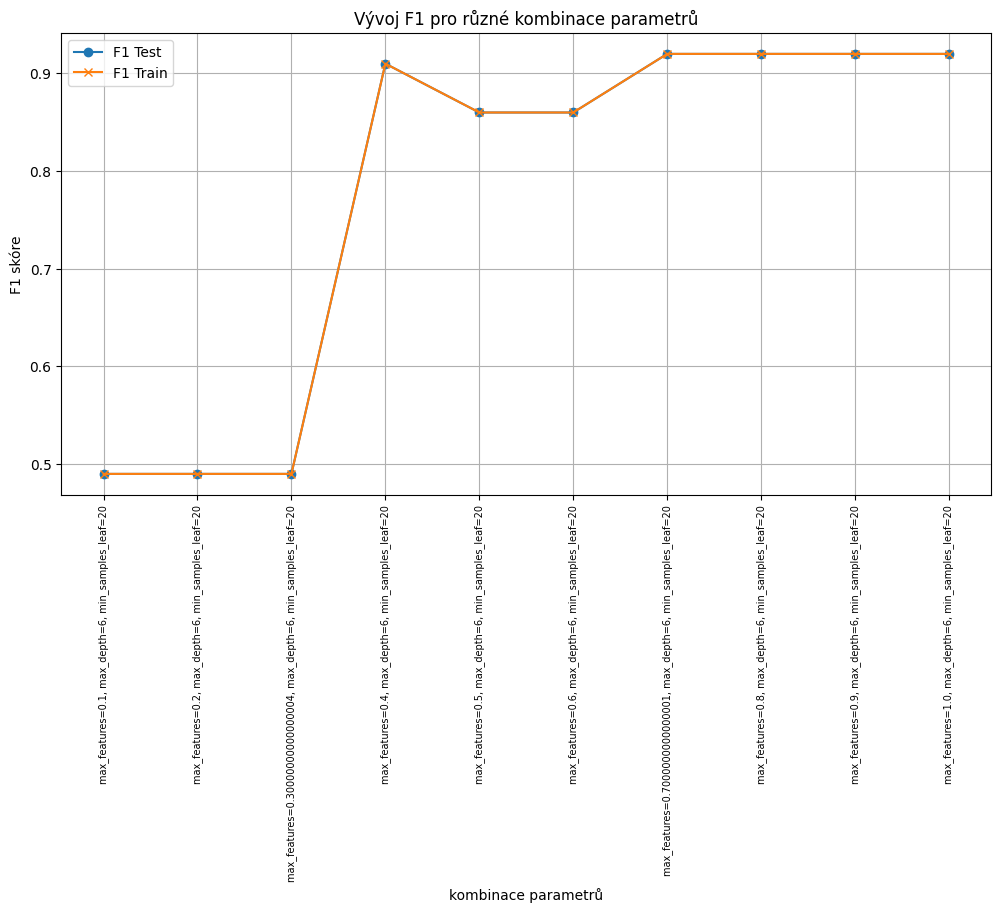

In [69]:
from sklearn.metrics import f1_score

#výchozí fixní hodnoty parametrů, v násldujících for cyklech budeme vždy měnit jeden z nich a sledovat jeho vliv na přesnost modelu
fixed_max_depth = 6
fixed_min_samples_leaf = 20
fixed_max_features = 0.7

#tvorba seznamů hodnot pparametrů přes které budeme iterovat
max_depth_values = range(1,31)
min_samples_leaf_values = range(1,100, 10)
max_features_values = np.arange(0.1, 1.1, 0.1).tolist()

#seznamy pro ukládání výsledků
f1_train_list = []
f1_test_list = []
parameter_combinations = []

#změny max_depth
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(
        max_features=fixed_max_features,
        max_depth=max_depth,
        min_samples_leaf=fixed_min_samples_leaf,
        random_state=16
    )
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    f1_train_list.append(round(f1_train, 2))
    f1_test_list.append(round(f1_test, 2))
    parameter_combinations.append(f"max_features={fixed_max_features}, max_depth={max_depth}, min_samples_leaf={fixed_min_samples_leaf}")

    print(f"max_features: {fixed_max_features}, max_depth: {max_depth}, min_samples_leaf: {fixed_min_samples_leaf}")
    print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations)

f1_train_list = []
f1_test_list = []
parameter_combinations = []

#změny  min_samples_leaf
for min_samples_leaf in min_samples_leaf_values:
    clf = tree.DecisionTreeClassifier(
        max_features=fixed_max_features,
        max_depth=fixed_max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=16
    )
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    f1_train_list.append(round(f1_train, 2))
    f1_test_list.append(round(f1_test, 2))
    parameter_combinations.append(f"max_features={fixed_max_features}, max_depth={fixed_max_depth}, min_samples_leaf={min_samples_leaf}")

    print(f"max_features: {fixed_max_features}, max_depth: {fixed_max_depth}, min_samples_leaf: {min_samples_leaf}")
    print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations)

f1_train_list = []
f1_test_list = []
parameter_combinations = []

#změny max_features
for max_features in max_features_values:
    clf = tree.DecisionTreeClassifier(
        max_features=max_features,
        max_depth=fixed_max_depth,
        min_samples_leaf=fixed_min_samples_leaf,
        random_state=16
    )
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    f1_train_list.append(round(f1_train, 2))
    f1_test_list.append(round(f1_test, 2))
    parameter_combinations.append(f"max_features={max_features}, max_depth={fixed_max_depth}, min_samples_leaf={fixed_min_samples_leaf}")

    print(f"max_features: {max_features}, max_depth: {fixed_max_depth}, min_samples_leaf: {fixed_min_samples_leaf}")
    print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

vizualizuj_do_grafu(f1_train_list, f1_test_list, parameter_combinations)

### Výstup úlohy

1. Naučený model rozhodovacího stromu schopný klasifikovat typy land cover s vyváženým poměrem přesnosti a generalizace.
2. Zpráva, která obsahuje:
    - Analýzu generalizace modelu. Citlivost parametrů modelu. 
    - Hodnocení modelu na testovacích datech (přesnost).
    - Diskuzi o problémech s přeučením a šumem a jejich řešeních.

## Zpráva k úloze
### 1. Analýza generalizace modelu
- pro parametr *max_depth*, označující maximální hloubku stromu, byla zvolena hodnota 6, nižší hodnoty vedly k menší přesnosti modelu, vyšší hodnoty stagnovaly. Nižší volba tohoto parametru z více možností se shodnou přesností by měla vést k rychlejšímu modelu.
- pro parametr *min_samples_leaf*, který volí minimální počet vzorků v listovém uzlu, byla zvolena hodnota 13. Při testování bylo zjištěno, že při hodnotách vyšších než 30 začíná být model přeučený.
- pro parametr *max_features* byla po testování zvolena hodnoota 0.7, při volbě nižších hodnot byla přesnost modelu nižší, při vyšších honotách stagnovala, ale přidávala by výpočetní náročnost.

- nejcitlivějším parametrem se jeví max_depth, tedy maximání hloubka stromu, další dva testované parametry nemají na přesnost modelu takový vliv.

### 2. Hodnocení modelu na testovacích datech
- celková přesnost modelu na testovacích datech při zvolených hyperparametrech je 92 %.
- matice chyb (níže) říká, že nejlépe je klasifikována třída "trávník, nejhorších výsledků dosahuje třída "les". Tabulka nazvaná přesnost klasifikace zobrazuje také precision, recall a f1 skóre jednotlivých klasifikovaných tříd.

| Třída       | les   | město | trávník | voda  |
|-------------|-------|-------|---------|-------|
| **les**     | 3040  | 107   | 422     | 85    |
| **město**   | 414   | 4569  | 425     | 98    |
| **trávník** | 72    | 113   | 16516   | 86    |
| **voda**    | 78    | 136   | 442     | 3397  |

Přesnost klasifikace:
              precision    recall  f1-score   support

         les       0.84      0.83      0.84      3654
       město       0.93      0.83      0.88      5506
     trávník       0.93      0.98      0.95     16787
        voda       0.93      0.84      0.88      4053

### 3. Diskuze o problémech s přeučením a šumem
- Z principu vytváření dat dochází k blízkosti mezi výsledky modelu pro trénovací a testovací sadu - šum je v nich rozmístěn rovnoměrně a tak je vykazována velmi podobná přesnost výsledků pro oba datasety. Pro redukci vlivu šummu by bylo vhodné otestovat jiné modely naž DecisionTree.
- Pokud by docházelo k přeučení modelu, při vysokých přesnostech na trénovacích datech by bylo dosahováno horších výsledků na datech testovacích. K tomu může typicky docházet při velké hloubce stromu, té lze předejít vhodným nastavením parametru *max_depth*. Přílišné hloubce stromu a tím i přeučení modelu lze předejít také nastavením parametru *min_samples_leaf* na vyšší hodnoty - dělení na další větve se zastaví, pokud by do každé z nich nepřipadlo požadované množství pozorování. 

In [70]:
pass 

Výsledek Vašeho řešení zašlete do 23.1.2025 na email: lukas.brodsky@natur.cuni.cz 